In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from pathlib import Path
from scipy.integrate import solve_ivp

sns.set_theme("paper", style="whitegrid", rc={"figure.facecolor": "white"})

In [2]:
data_path = Path() / "data"
images_path = Path() / "images"
data_path.mkdir(exist_ok=True)
images_path.mkdir(exist_ok=True)

In [3]:
def seihr(t, y, beta, b, epsilon, r1, r2, sigma, gamma, eta, omega, mu1, mu2, mu):
    S, E, I, H, R = y
    dS_dt = -beta * S * I * (1 - b)  - epsilon * beta * S * E * (1 - b) - mu * S
    dE_dt = beta * S * I * (1 - b) + epsilon * beta * S * E * (1 - b) - sigma * E + r1 * R - mu * E
    dI_dt = sigma * E - gamma * I - eta * I - mu1 * I + r2 * H - mu * I
    dH_dt = eta * I - omega * H - mu2 * H - r2 * H - mu * H
    dR_dt = gamma * I + omega * H - r1 * R - mu * R
    return np.array([dS_dt, dE_dt, dI_dt, dH_dt, dR_dt])

In [4]:
N = 1000
S_0, E_0, I_0, H_0, R_0 = N - 51, 1, 50, 0, 0
y0 = np.array([S_0, E_0, I_0, H_0, R_0]) / N

beta = 0.5
b = 0
epsilon = 0.7
r1 = 0.4
r2 = 0.5
sigma = 0.9
gamma = 1 / 14
eta = 1 / 7
omega = 0.5
mu1 = 0.05
mu2 = 0.01
mu = 0
params_dict = {
    "beta": beta,
    "b": b,
    "epsilon": epsilon,
    "r1": r1,
    "r2": r2,
    "sigma": sigma,
    "gamma": gamma,
    "eta": eta,
    "omega": omega,
    "mu1": mu1,
    "mu2": mu2,
    "mu": mu
}
n_days = 60  # 2 months
t_data = np.arange(0, n_days, 1)
t_span = (t_data[0], t_data[-1])
sol = solve_ivp(seihr, t_span, y0, args=params_dict.values(), dense_output=True)
y_data = sol.sol(t_data)

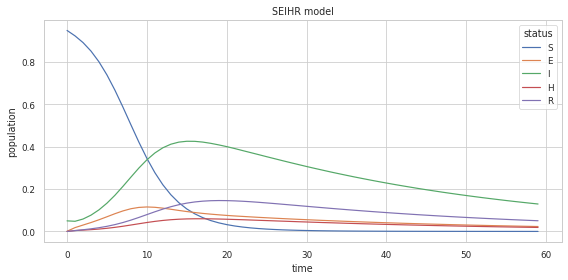

In [5]:
model_name = "SEIHR"
populations_names = list(model_name)
data = (
    pd.DataFrame(y_data.T, columns=populations_names)
    .assign(time=t_data)
    .melt(id_vars="time", var_name="status", value_name="population")
)

fig, ax = plt.subplots(figsize=(8, 4), facecolor="white")
sns.lineplot(
    data=data,
    x="time",
    y="population",
    hue="status",
    legend=True,
    ax=ax
)
ax.set_title(f"{model_name} model")
fig.tight_layout()
fig.savefig(images_path / f"{model_name}_dynamics.png", dpi=300, transparent=False)

In [6]:
n_betas = 1001
betas = np.linspace(0, 1, n_betas)
max_infect_array = np.zeros(shape=(n_betas, 4), dtype=float)
for i, beta in enumerate(betas):
    sol = solve_ivp(
        seihr,
        t_span,
        y0,
        t_eval=t_data,
        args=(beta, b, epsilon, r1, r2, sigma, gamma, eta, omega, mu1, mu2, mu),
        dense_output=True
    )
    y_data = sol.sol(t_data)
    E_max = y_data[1, :].max()
    I_max = y_data[2, :].max()
    EI_max = y_data[1:3, :].sum(axis=0).max()
    max_infect_array[i, :] = [beta, E_max, I_max, EI_max]

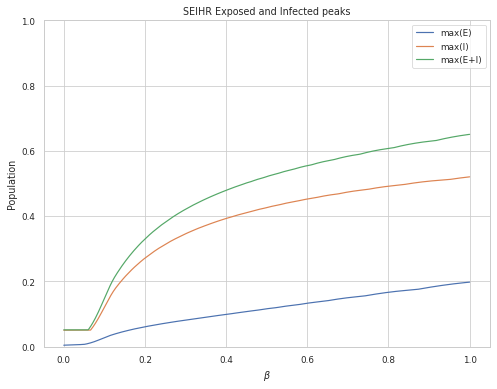

In [7]:
fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")
ax.plot(max_infect_array[:, 0], max_infect_array[:,1], label="max(E)")
ax.plot(max_infect_array[:, 0], max_infect_array[:,2], label="max(I)")
ax.plot(max_infect_array[:, 0], max_infect_array[:,3], label="max(E+I)")
ax.legend()
ax.set_xlabel(r"$\beta$")
ax.set_ylabel("Population")
ax.set_ylim(0, 1)
ax.set_title(f"{model_name} Exposed and Infected peaks")
fig.savefig(images_path / f"{model_name}_infection_peaks.png", dpi=300)

In [8]:
with open(data_path / f"max_infection_{model_name}.npy", "wb") as f:
    np.save(f, max_infect_array)